In [87]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split

In [88]:
df_treino = pd.read_csv('dataset_treino.csv', keep_default_na=False)
df_teste = pd.read_csv('dataset_teste.csv')
df_teste_interpolate= pd.read_csv('dataset_teste_interpolate.csv')
df_treino.head(1)

,Ano,Mes,Hora,Normal,HorarioEconomico,Autoconsumo,Injecao,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,hora_sin,hora_cos,autoconsumo_ratio,total_consumo
0,2021,9,0.0,0.0,0.0,0.0,3,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,0.0,1.0,0.0,0.0


## Modelo #1

Distribuição original: [ 882  346  878 6221  485]
Após SMOTE: [6221 6221 6221 6221 6221]
Epoch 1/30


c:\Users\games\anaconda3\envs\lcd_scaa\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7452 - loss: 0.6128 - val_accuracy: 0.8859 - val_loss: 0.3133
Epoch 2/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8247 - loss: 0.4327 - val_accuracy: 0.9396 - val_loss: 0.1995
Epoch 3/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8498 - loss: 0.3800 - val_accuracy: 0.9473 - val_loss: 0.1763
Epoch 4/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8676 - loss: 0.3426 - val_accuracy: 0.9515 - val_loss: 0.1665
Epoch 5/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8815 - loss: 0.3121 - val_accuracy: 0.9489 - val_loss: 0.1665
Epoch 6/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8925 - loss: 0.2869 - val_accuracy: 0.9521 - val_loss: 0.1557
Epoch 7/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9018 - loss: 0.2655 - val_accuracy: 0.9486 - val_loss: 0.1499
Epoch 8/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9103 - loss: 0.2467 - val_accurac

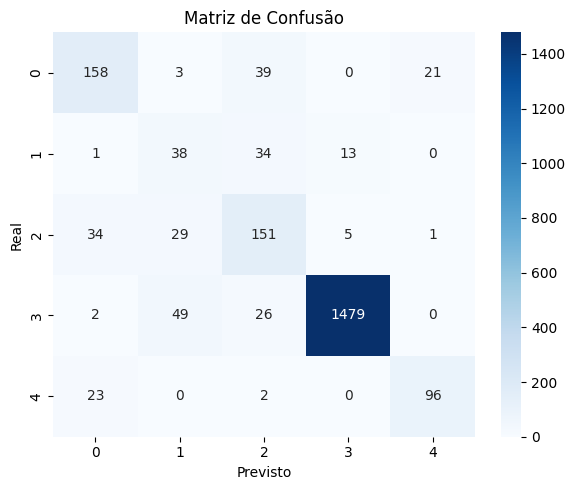

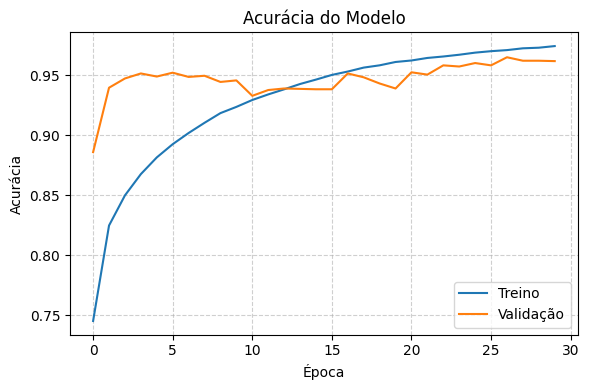

In [89]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------------------------------------------------
# 1. Fixar seeds para reprodutibilidade
# -------------------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -------------------------------------------------------------------------
# 2. Preparar dados
# -------------------------------------------------------------------------
df = df_treino.copy()

target_col = "Injecao"
encoder = LabelEncoder()
y = encoder.fit_transform(df[target_col])

X = df.drop(columns=[target_col]).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

smote = SMOTE(k_neighbors=2, random_state=SEED)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

print("Distribuição original:", np.bincount(y_train))
print("Após SMOTE:", np.bincount(y_train_res))

n_classes = len(np.unique(y))

# -------------------------------------------------------------------------
# 3. Definir modelo (com inicialização fixa)
# -------------------------------------------------------------------------
initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer, input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=initializer)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------------------------------------------------------
# 4. Treinar modelo
# -------------------------------------------------------------------------
history = model.fit(
    x_train_res, y_train_res,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

# -------------------------------------------------------------------------
# 5. Avaliar modelo
# -------------------------------------------------------------------------
loss, acc = model.evaluate(x_test, y_test)
print(f"\nAcurácia no teste: {acc:.4f}")

preds = model.predict(x_test)
pred_classes = np.argmax(preds, axis=1)

print("\nRelatório de Classificação:")
print(classification_report(
    y_test, pred_classes,
    target_names=[str(c) for c in encoder.classes_]
))

# -------------------------------------------------------------------------
# 6. Visualizações
# -------------------------------------------------------------------------
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


              feature  importance
5         Autoconsumo    0.172595
16           hora_cos    0.074955
17  autoconsumo_ratio    0.055445
3              Normal    0.043920
9            temp_max    0.039111
11           humidity    0.033303
2                Hora    0.032940
1                 Mes    0.028766
15           hora_sin    0.025136
14         clouds_all    0.016515
8            temp_min    0.016425
12         wind_speed    0.016425
18      total_consumo    0.015336
7          feels_like    0.013158
10           pressure    0.012976
4    HorarioEconomico    0.010708
13            rain_1h    0.006806
6                temp    0.006624
0                 Ano    0.005354


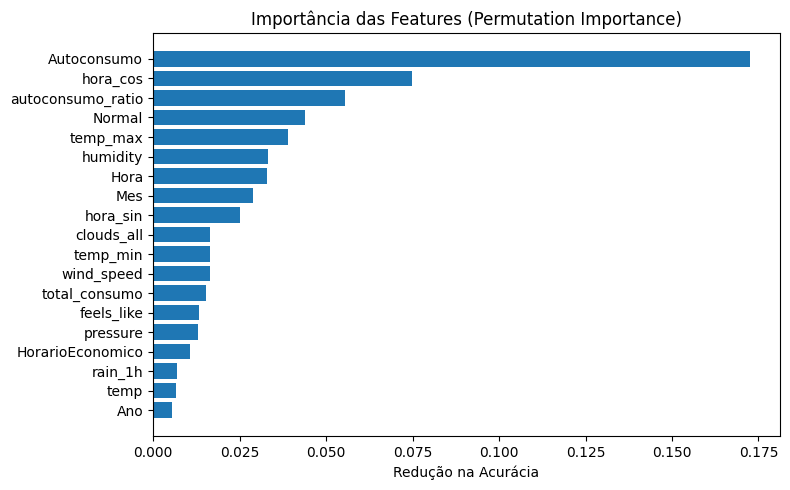

In [90]:
from sklearn.metrics import accuracy_score

def permutation_importance_keras(model, X, y, n_repeats=5):
    baseline = accuracy_score(y, np.argmax(model.predict(X, verbose=0), axis=1))
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        X_permuted = X.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_permuted[:, i])
            y_pred = np.argmax(model.predict(X_permuted, verbose=0), axis=1)
            scores.append(accuracy_score(y, y_pred))
        importances[i] = baseline - np.mean(scores)
    return importances

# calcular importância
importances = permutation_importance_keras(model, x_test.copy(), y_test, n_repeats=5)

# ordenar
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance)

# gráfico
plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.gca().invert_yaxis()
plt.title('Importância das Features (Permutation Importance)')
plt.xlabel('Redução na Acurácia')
plt.tight_layout()
plt.show()


In [92]:
df = df_teste_interpolate.copy()

# Selecionar apenas colunas numéricas como entrada
X = df.select_dtypes(np.number).copy()

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# gerar previsões de classe
mapa_injecao = {
    'None': 3,
    'Low': 1,
    'Medium': 2,
    'High': 0,
    'Very High': 4
}

# Inverter o dicionário
mapa_injecao_inv = {v: k for k, v in mapa_injecao.items()}

# Gerar previsões de classe
preds_final = model.predict(X_scaled)
pred_classes = np.argmax(preds_final, axis=1)

# Converter de volta para os rótulos originais
pred_labels = [mapa_injecao_inv[v] for v in pred_classes]

# criar DataFrame final
output = pd.DataFrame({
    "RowId": np.arange(1, len(pred_labels) + 1),
    "Result": pred_labels
})

# exportar para CSV
output.to_csv("predicoes_smote3.csv", index=False)
print("Arquivo 'predicoes_injecao.csv' criado com sucesso.")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Arquivo 'predicoes_injecao.csv' criado com sucesso.
